In [35]:
import os
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt

import NN

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_etf_data(ETF):
    NNtype = "RNN"
    if ETF == "SPY":
        inputs_lag = cfg.SPYfeatures[NNtype]
    elif ETF == "DIA":
        inputs_lag = cfg.DIAfeatures[NNtype]
    elif ETF == "QQQ":
        inputs_lag = cfg.QQQfeatures[NNtype]

    traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
    validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
    testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
    
    features_col = []
    for i in inputs_lag:
        features_col.append("Return_" + str(i))
    target_col   = 'Target'
    

    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

    return (trainloader, trainmu, trainsigma), (validloader, validmu, validsigma), (testloader, testmu, testsigma)


In [3]:
import torch.nn as nn 

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers= 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    

In [4]:
def train_model(model, traindata, validdata, params):
    train_loss = []
    val_loss = []
    
    epochs = params["epochs"]
    lr = params["lr"]
    trainloader = traindata[0]
    mu_train = traindata[1]
    sigma_train = traindata[2]
    validloader = validdata[0]
    mu_val = validdata[1]
    sigma_val = validdata[2]
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    for i in range(epochs):
        for seq, labels in trainloader:
            model.train()
            optimizer.zero_grad()
            
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            
            y_pred = model(seq.squeeze())
            
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
          
      ###############################
      ###########Validation##########
      ###############################
        if i%2 == 0:
            model.eval()
            with torch.no_grad():
                loss_valid = 0
                for seq, labels in validloader:
                    y_pred = model(seq.squeeze())
                    #loss_valid += loss_function((y_pred ), (labels))
                    loss_valid += loss_function((y_pred * sigma_val) + mu_val, (labels * sigma_val) + mu_val )

                val_loss.append(loss_valid.item())
                loss_train = 0 
                for seq, labels in trainloader:
                    y_pred = model(seq.squeeze())
                    #loss_train += loss_function((y_pred), labels )

                    loss_train += loss_function((((y_pred) * sigma_train) + mu_train), (labels * sigma_train) + mu_train)
                train_loss.append(loss_train.item())
            print(f'epoch: {i:3} train_loss: {loss_train:10.10f} val_loss: {loss_valid:10.10f} ')
            
#     plt.plot(train_loss)
#     plt.plot(val_loss)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU, PT_test

def evaluate_model(model, testdata):
    testloader = testdata[0]
    mu = np.array(testdata[1])
    sigma = np.array(testdata[2])
    valid_targets = []
    valid_preds = []
    with torch.no_grad():
        for seq, target in testloader:
            valid_preds.append(model(seq.squeeze()))
            valid_targets += target.numpy().tolist()


     
    validRMSE = np.sqrt(mean_squared_error((valid_targets * sigma) + mu, (valid_preds*sigma) + mu))
    validMAE = mean_absolute_error((valid_targets * sigma) + mu, (valid_preds*sigma + mu))
    validMAPE = mean_absolute_percentage_error((np.array(valid_targets) * sigma) + mu , (np.array(valid_preds) * sigma) + mu)
    validTheilU = theilU((np.array(valid_targets)* sigma) + mu , (np.array(valid_preds) * sigma) + mu)

    print("MAE : {:.4f} |  MAPE  : {:.4f} |  RMSE : {:.5f} | Theil-U {:.4f}".format(validMAE, validMAPE, validRMSE, validTheilU))
    
    sns.set()
    fig, ax = plt.subplots(figsize = (12,6))
    dataDf = utils.load_file(os.path.join("data", ETF, "RNN", "Test.pkl"))
    plt.plot(dataDf.index, valid_targets, label="Targets")
    plt.plot(dataDf.index, valid_preds, label="Predictions")
    ax.set_ylabel('Returns')
    ax.set_title(ETF + " - LSTM")
    plt.show()
    
    return {"MAE": validMAE, "RMSE": validRMSE, "MAPE": validMAPE, "Theil-U":validTheilU}

def predict(model, testdata):
    testloader = testdata[0]
    mu = testdata[1]
    sigma = testdata[2]
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for seq, target in testloader:
            predicted_labels.append(model(seq.squeeze()))
    return  (predicted_labels * np.array(sigma)) + np.array(mu)

### Generating Table 4 with baseline parameters and predictions


==========SPY==========
epoch:   0 train_loss: 0.0690251812 val_loss: 0.0122043574 
epoch:   2 train_loss: 0.0686321557 val_loss: 0.0121672936 
epoch:   4 train_loss: 0.0680138320 val_loss: 0.0122706676 
epoch:   6 train_loss: 0.0673585832 val_loss: 0.0124184107 
epoch:   8 train_loss: 0.0678520054 val_loss: 0.0126735624 
epoch:  10 train_loss: 0.0643056482 val_loss: 0.0126956766 
epoch:  12 train_loss: 0.0643573925 val_loss: 0.0128518902 
epoch:  14 train_loss: 0.0653340295 val_loss: 0.0139168380 
epoch:  16 train_loss: 0.0700799972 val_loss: 0.0123883942 
epoch:  18 train_loss: 0.0591861792 val_loss: 0.0120272702 
epoch:  20 train_loss: 0.0648921728 val_loss: 0.0127996132 
epoch:  22 train_loss: 0.0614165105 val_loss: 0.0136536881 
epoch:  24 train_loss: 0.0555191264 val_loss: 0.0134765189 
epoch:  26 train_loss: 0.0587172098 val_loss: 0.0132612232 
epoch:  28 train_loss: 0.0654883385 val_loss: 0.0134444525 
epoch:  30 train_loss: 0.0527851768 val_loss: 0.0127490275 
epoch:  32 train

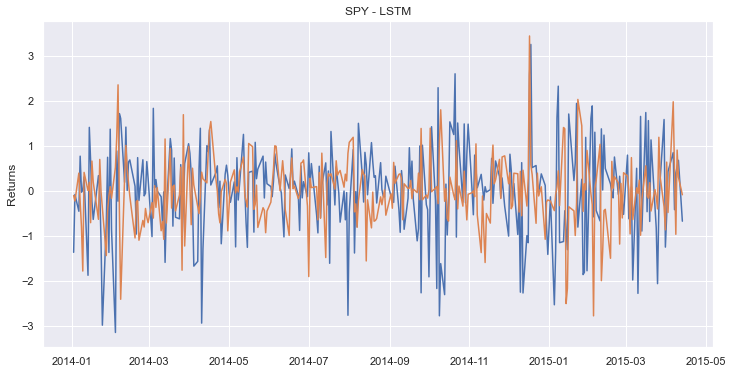

{'MAE': 0.007100696900928635, 'RMSE': 0.00925323021954509, 'MAPE': 307.535552026486, 'Theil-U': 0.7186940249641319}
==========DIA==========
epoch:   0 train_loss: 0.0570211448 val_loss: 0.0102380970 
epoch:   2 train_loss: 0.0566759333 val_loss: 0.0102992291 
epoch:   4 train_loss: 0.0562306121 val_loss: 0.0103617581 
epoch:   6 train_loss: 0.0558329597 val_loss: 0.0104093831 
epoch:   8 train_loss: 0.0544659644 val_loss: 0.0105005139 
epoch:  10 train_loss: 0.0534198657 val_loss: 0.0104979388 
epoch:  12 train_loss: 0.0535426587 val_loss: 0.0105073610 
epoch:  14 train_loss: 0.0515482314 val_loss: 0.0106730703 
epoch:  16 train_loss: 0.0533607900 val_loss: 0.0106280055 
epoch:  18 train_loss: 0.0503455177 val_loss: 0.0108315991 
epoch:  20 train_loss: 0.0491704345 val_loss: 0.0111264791 
epoch:  22 train_loss: 0.0505398326 val_loss: 0.0108178295 
epoch:  24 train_loss: 0.0464616790 val_loss: 0.0120336125 
epoch:  26 train_loss: 0.0459573418 val_loss: 0.0122841597 
epoch:  28 train_los

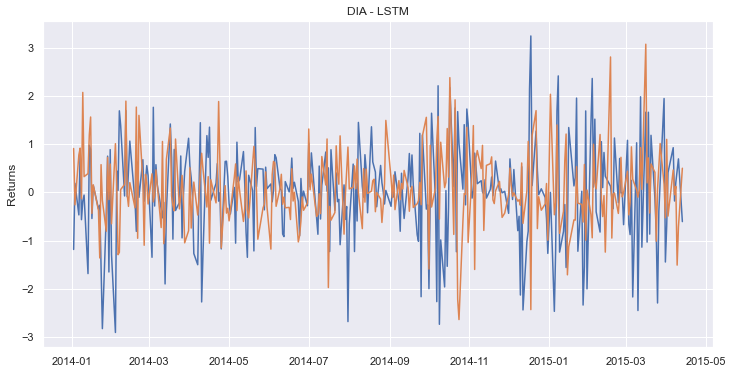

{'MAE': 0.0067417970831144085, 'RMSE': 0.009084798438034133, 'MAPE': 27230474.35534548, 'Theil-U': 0.700429262569687}
==========QQQ==========
epoch:   0 train_loss: 0.0793254599 val_loss: 0.0148936994 
epoch:   2 train_loss: 0.0784419551 val_loss: 0.0148517555 
epoch:   4 train_loss: 0.0777359456 val_loss: 0.0147414645 
epoch:   6 train_loss: 0.0763303936 val_loss: 0.0148547906 
epoch:   8 train_loss: 0.0821008459 val_loss: 0.0152843688 
epoch:  10 train_loss: 0.0737454668 val_loss: 0.0150366239 
epoch:  12 train_loss: 0.0718956217 val_loss: 0.0152395144 
epoch:  14 train_loss: 0.0707705021 val_loss: 0.0153583428 
epoch:  16 train_loss: 0.0719746798 val_loss: 0.0159177165 
epoch:  18 train_loss: 0.0774939880 val_loss: 0.0155087626 
epoch:  20 train_loss: 0.0846102610 val_loss: 0.0179534778 
epoch:  22 train_loss: 0.0860654861 val_loss: 0.0190814137 
epoch:  24 train_loss: 0.0851677954 val_loss: 0.0202088952 
epoch:  26 train_loss: 0.0910318121 val_loss: 0.0223947614 
epoch:  28 train_l

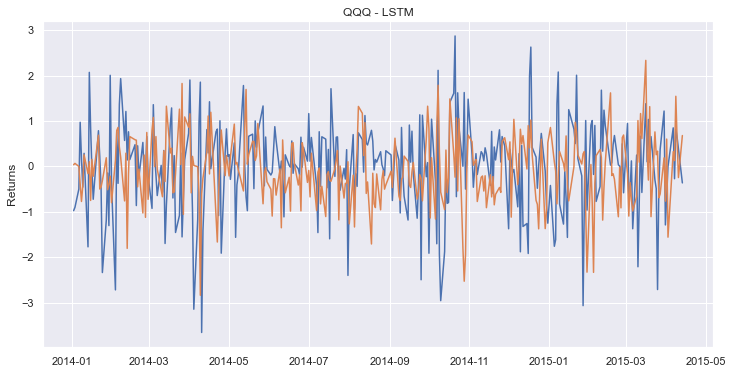

{'MAE': 0.008507411957450162, 'RMSE': 0.010933604975983339, 'MAPE': 202899022.7151264, 'Theil-U': 0.7118277727750364}


In [6]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4_baseline = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
modelPredictions_baseline = {}

for ETF in ETF_params:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    
    modelPredictions_baseline[ETF] = predicted
    
    Table4_baseline[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
    print(results)

In [7]:
Table4_baseline

,Statistic,SPY,DIA,QQQ
0,MAE,0.007101,6.741797e-03,8.507412e-03
1,MAPE,307.535552,2.723047e+07,2.028990e+08
2,RMSE,0.009253,9.084798e-03,1.093360e-02
3,THEIL-U,0.718694,7.004293e-01,7.118278e-01


### SAME TEST WITH DROPOUT AND L2 REGULARIZATION




==========SPY==========
epoch:   0 train_loss: 0.0690427199 val_loss: 0.0122075472 
epoch:   2 train_loss: 0.0688537359 val_loss: 0.0121552227 
epoch:   4 train_loss: 0.0679928958 val_loss: 0.0122097218 
epoch:   6 train_loss: 0.0673857033 val_loss: 0.0123944161 
epoch:   8 train_loss: 0.0670811385 val_loss: 0.0124104759 
epoch:  10 train_loss: 0.0653687492 val_loss: 0.0124573912 
epoch:  12 train_loss: 0.0693915337 val_loss: 0.0129990540 
epoch:  14 train_loss: 0.0728379413 val_loss: 0.0135081811 
epoch:  16 train_loss: 0.0656177476 val_loss: 0.0126806870 
epoch:  18 train_loss: 0.0653954670 val_loss: 0.0128598390 
epoch:  20 train_loss: 0.0665392354 val_loss: 0.0126590421 
epoch:  22 train_loss: 0.0645586401 val_loss: 0.0121987816 
epoch:  24 train_loss: 0.0645662993 val_loss: 0.0132962391 
epoch:  26 train_loss: 0.0655899048 val_loss: 0.0132257864 
epoch:  28 train_loss: 0.0644833744 val_loss: 0.0139176743 
epoch:  30 train_loss: 0.0631152764 val_loss: 0.0149669088 
epoch:  32 train

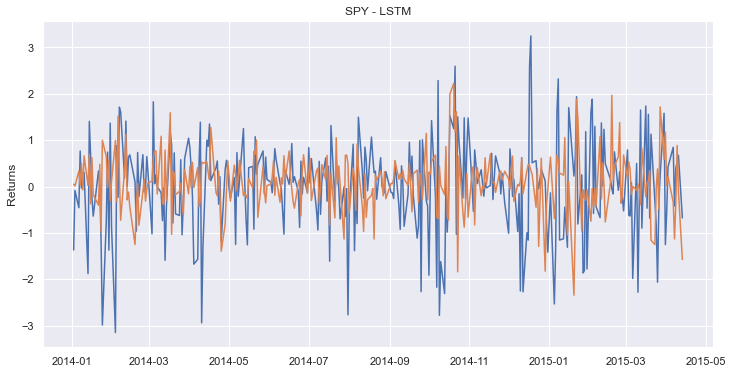

{'MAE': 0.006724704687917525, 'RMSE': 0.008670947956078938, 'MAPE': 339.4305268546817, 'Theil-U': 0.7193496417070454}
==========DIA==========
epoch:   0 train_loss: 0.0569721013 val_loss: 0.0102404514 
epoch:   2 train_loss: 0.0566174015 val_loss: 0.0102963531 
epoch:   4 train_loss: 0.0561512262 val_loss: 0.0103708021 
epoch:   6 train_loss: 0.0557030402 val_loss: 0.0104218647 
epoch:   8 train_loss: 0.0564717539 val_loss: 0.0103299739 
epoch:  10 train_loss: 0.0553225242 val_loss: 0.0103054112 
epoch:  12 train_loss: 0.0540384315 val_loss: 0.0103050852 
epoch:  14 train_loss: 0.0573483221 val_loss: 0.0102545330 
epoch:  16 train_loss: 0.3389849365 val_loss: 0.0103617860 
epoch:  18 train_loss: 0.0928442404 val_loss: 0.0103236614 
epoch:  20 train_loss: 0.0552709475 val_loss: 0.0103330621 
epoch:  22 train_loss: 0.0589724630 val_loss: 0.0103961211 
epoch:  24 train_loss: 0.0729269162 val_loss: 0.0103016170 
epoch:  26 train_loss: 0.0527210534 val_loss: 0.0103275729 
epoch:  28 train_l

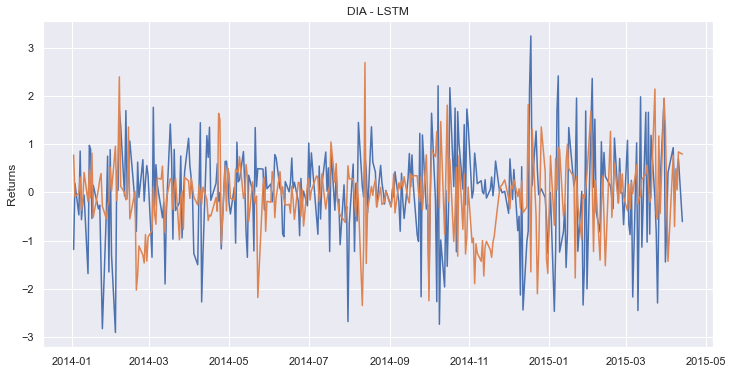

{'MAE': 0.0070201846948993955, 'RMSE': 0.008991342526840048, 'MAPE': 754749644.6328019, 'Theil-U': 0.7091364358676273}
==========QQQ==========
epoch:   0 train_loss: 0.0792779624 val_loss: 0.0148887010 
epoch:   2 train_loss: 0.0784068108 val_loss: 0.0148495166 
epoch:   4 train_loss: 0.0775551274 val_loss: 0.0147945378 
epoch:   6 train_loss: 0.0783847347 val_loss: 0.0149850613 
epoch:   8 train_loss: 0.0789952949 val_loss: 0.0155580081 
epoch:  10 train_loss: 0.0785457045 val_loss: 0.0156810377 
epoch:  12 train_loss: 0.0752379522 val_loss: 0.0173140429 
epoch:  14 train_loss: 0.0751170292 val_loss: 0.0176909957 
epoch:  16 train_loss: 0.0740069598 val_loss: 0.0200374909 
epoch:  18 train_loss: 0.0721476674 val_loss: 0.0190939847 
epoch:  20 train_loss: 0.0715326667 val_loss: 0.0169981606 
epoch:  22 train_loss: 0.0759154484 val_loss: 0.0201832633 
epoch:  24 train_loss: 0.0753518045 val_loss: 0.0193465445 
epoch:  26 train_loss: 0.0761069804 val_loss: 0.0192853734 
epoch:  28 train_

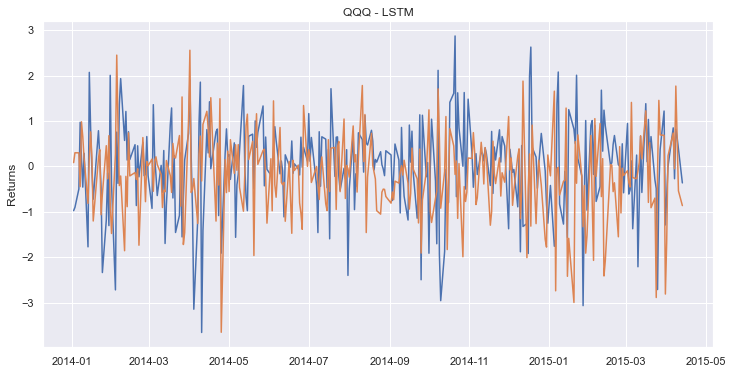

{'MAE': 0.008594584886641018, 'RMSE': 0.011122376653686226, 'MAPE': 109460100.41964762, 'Theil-U': 0.6635385766420835}


In [8]:
ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

Table4 = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
modelPredictions = {}

for ETF in ETF_params:
    
    print("="*10 + ETF +"="*10)
    train_data, valid_data, test_data =  get_etf_data(ETF)
    model = LSTM()
    train_model(model, train_data, valid_data, ETF_params[ETF])
    results = evaluate_model(model, test_data)
    predicted = predict(model, test_data)
    
    modelPredictions[ETF] = predicted
    Table4[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
    print(results)


In [9]:
Table4

,Statistic,SPY,DIA,QQQ
0,MAE,0.006725,7.020185e-03,8.594585e-03
1,MAPE,339.430527,7.547496e+08,1.094601e+08
2,RMSE,0.008671,8.991343e-03,1.112238e-02
3,THEIL-U,0.719350,7.091364e-01,6.635386e-01


# Plot

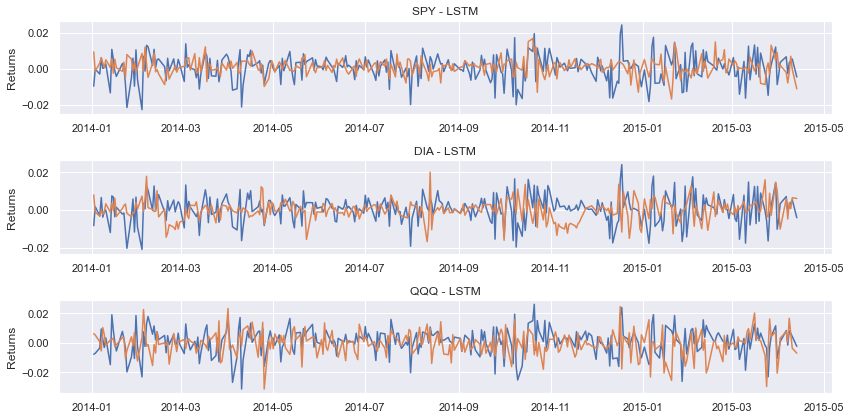

In [20]:
sns.set()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))

ETF_params = {
              "SPY": {"epochs": 80, "lr":0.001},
              "DIA": {"epochs": 80, "lr":0.001},
              "QQQ": {"epochs": 80, "lr":0.001},
             }

for ETF in ["SPY", "DIA", "QQQ"]:
    dataDf = utils.load_file(os.path.join("data", ETF, "RNN", "Test.pkl"))
    
    if ETF == "SPY":
        AX = ax1 # for the plot
    elif ETF == "DIA":
        AX = ax2 # for the plot
    else:
        AX = ax3 # for the plot
    
    AX.plot(dataDf.index, dataDf['Target'].values, label="Targets")
    AX.plot(dataDf.index, modelPredictions[ETF], label="Predictions")
    AX.set_ylabel('Returns')
    AX.set_title(ETF + " - LSTM")
plt.tight_layout()
plt.show()
fig.savefig('table/LSTMplot.png', bbox_inches='tight')

# Saving results

In [38]:
LSTM_RESULTS_PATH = "models_norm/LSTM_preds"

predictionDf_baseline = pd.DataFrame(modelPredictions_baseline)
predictionDf = pd.DataFrame(modelPredictions)

if not os.path.isdir(LSTM_RESULTS_PATH):
    os.mkdir(LSTM_RESULTS_PATH)

predictionDf_baseline.to_csv(LSTM_RESULTS_PATH + "/Predictions_baseline", index=False)
predictionDf.to_csv(LSTM_RESULTS_PATH + "/Predictions", index=False)

# Stats - Table

## Table 5

In [39]:
# Pesaran-Timmermann test
#https://purehost.bath.ac.uk/ws/portalfiles/portal/189214729/Forecasting_directional_change.pdf
#https://www.real-statistics.com/time-series-analysis/forecasting-accuracy/pesaran-timmermann-test/
#https://www.economicsnetwork.ac.uk/showcase/cook_directional
#
#
# Diebold Mariano test
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.


Table = pd.DataFrame()
Table_bis = pd.DataFrame()

# LSTM Predictions
LSTM_predictionsDf = pd.read_csv(LSTM_RESULTS_PATH + "/Predictions")

for ETF in ['SPY', 'DIA', 'QQQ']:
    TablePT = pd.DataFrame({"Test":"PT", "ETF":[ETF]})
    TableDM = pd.DataFrame({"Test":"DM", "ETF":[ETF]})
    for NNtype in ['MLP', 'RNN']:  
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        # Loading ARMA prediction for this ETF
        ARMApredsDf = pd.read_pickle(os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
        ARMApred = ARMApredsDf["Predictions"].to_list()
        
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl")) #Test.pkl = Out of sample df
        outOfSampleMu, outOfSampleSigma = df.Return.mean(), df.Return.std()     
        
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=True, mu=outOfSampleMu, sigma=outOfSampleSigma)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          500,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader, mu=outOfSampleMu, sigma=outOfSampleSigma)
        
        
        # compare prediction from both model
        LSTMpred = LSTM_pred_df[ETF].to_list()
        pred_lst = modelloaded.predict(dataloader, mu=outOfSampleMu, sigma=outOfSampleSigma)
        actual_lst = df['Target'].to_list()
        
        TableDM[NNtype] = utils.dm_test(actual_lst, LSTMpred, pred_lst, h = 1, crit="MSE")[0]
        
        TablePT[NNtype] = utils.PT_test(np.array(actual_lst), np.array(pred_lst))
        TablePT["LSTM"] = utils.PT_test(np.array(actual_lst), np.array(LSTMpred))
        
        # adding ARMA
        TableDM["ARMA"] = utils.dm_test(actual_lst, LSTMpred, ARMApred, h = 1, crit="MSE")[0]
        TablePT['ARMA'] = utils.PT_test(np.array(actual_lst), np.array(ARMApred))
        
    Table = pd.concat([Table,TablePT],ignore_index=True)
    Table_bis = pd.concat([Table_bis,TableDM],ignore_index=True)
Table5 = pd.concat([Table,Table_bis],ignore_index=True, sort=False)
Table5.set_index(['Test', 'ETF'], inplace=True)
Table5 = Table5[['ARMA', 'MLP', 'RNN', 'LSTM']]
# Table5.to_csv("table/Table5.csv", index=True)

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006160 | Test MAPE  : 272.958936 | Test RMSE : 0.008097 | Test Theil-U 0.711342
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006371 | Test MAPE  : 251.222612 | Test RMSE : 0.008189 | Test Theil-U 0.721020
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006285 | Test MAPE  : 62321.441073 | Test RMSE :

In [40]:
Table5

ARMA        MLP        RNN       LSTM
Test ETF                                            
PT   SPY  61.570179  35.362756  24.666646  20.882202
     DIA  57.674397  27.012180  22.172596  19.505709
     QQQ  51.548796  29.842847  15.814185  34.896780
DM   SPY   6.080490   2.205106   1.756546        NaN
     DIA   6.044383   1.372898   1.811841        NaN
     QQQ   5.503299   2.922817   1.342598        NaN

# To Work

==========SPY==========
epoch:   0 train_loss: 0.0689009577 val_loss: 0.0122042242 
epoch:   2 train_loss: 0.0681518391 val_loss: 0.0121849868 
epoch:   4 train_loss: 0.0674570203 val_loss: 0.0123699438 
epoch:   6 train_loss: 0.0671955645 val_loss: 0.0123899681 
epoch:   8 train_loss: 0.0726767555 val_loss: 0.0130656138 
MAE : 0.0057 |  MAPE  : 146.8761 |  RMSE : 0.00749 | Theil-U 0.8203


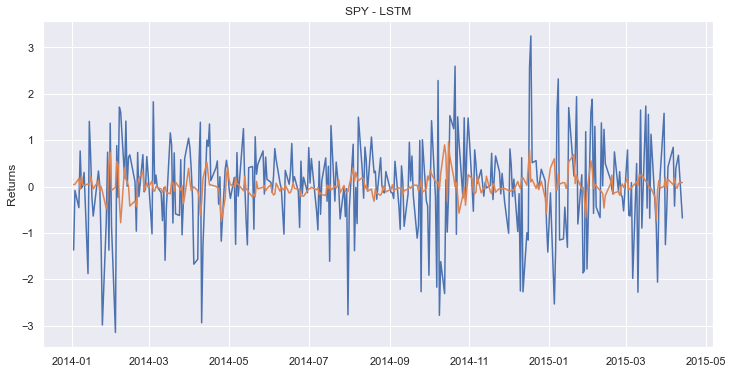

{'MAE': 0.0056523113944650025, 'RMSE': 0.007492577420864739, 'MAPE': 146.87614888357737, 'Theil-U': 0.8202901523401036}


In [138]:
ETF_params = {
              "SPY": {"epochs": 10, "lr":0.001},
              "DIA": {"epochs": 10, "lr":0.001},
              "QQQ": {"epochs": 10, "lr":0.001},
             }

Table4 = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})

ETF = "SPY"

print("="*10 + ETF +"="*10)
train_data, valid_data, test_data =  get_etf_data(ETF)
model = LSTM()
train_model(model, train_data, valid_data, ETF_params[ETF])
results = evaluate_model(model, test_data)
predicted = predict(model, test_data)

Table4[ETF] = [results['MAE'], results['MAPE'], results['RMSE'], results['Theil-U']]
print(results)